In [2]:
import numpy as np
import pyaudio
import wave
import matplotlib.pyplot as plt
import struct
from scipy.io import wavfile
import os
from sklearn.neural_network import MLPClassifier
import pandas as pd
from scipy.fftpack import fft,fftfreq
from scipy import signal
import math
from scipy.signal import butter, lfilter, freqz

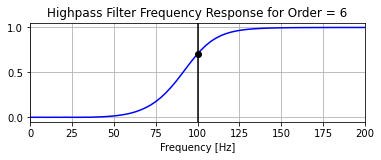

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='hp', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 48000    # sample rate, Hz
cutoff = 100  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_highpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, cutoff * 2)
plt.title(f"Highpass Filter Frequency Response for Order = {order}")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.show()

In [23]:
def get_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    x = []
    y = []
    
    for item in os.listdir(rel_dir):
        if item[0:7] == "lid_off" or item[0:15] == "testing_lid_off":
            y.append(0)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            
            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
        elif item[0:7] == "lid_on_" or item[0:15] == "testing_lid_on_":
            y.append(1)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.show()
    x = np.array(x)
    y = np.array(y)
    return x, y

In [24]:
x, y = get_data("./training")

nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=1) #hidden_layer_sizes=(?,)
nn.fit(x,y);

xt, yt = get_data("./testing")


pred =  nn.predict(xt)

print(pd.crosstab(yt, pred))

col_0   0   1
row_0        
0      10   0
1       0  10


In [18]:
def get_data_by_state(lid_status, rel_dir): # lid_status = "lid_off" for off, or "lid_on_" for on data
    width = 1000
    trim_value = 3750_00
    x = []
    if lid_status == "lid_off":
        y = np.zeros(10)
    else:
        y = np.ones(10)
    
    for item in os.listdir(rel_dir):
        if item[0:7] == lid_status:
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            
            
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.xlabel("Sample Number")
    plt.ylabel("Peak Magnitude")
    plt.title(f"{lid_status} Plot")
    plt.show()
    x = np.array(x)
    return x, y

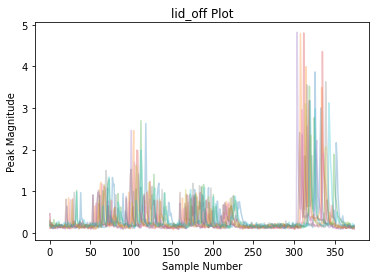

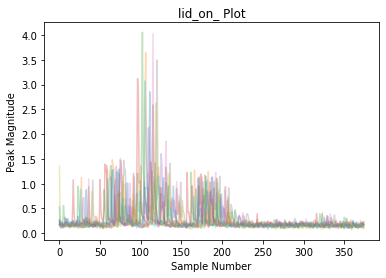

In [19]:
x1, y1 = get_data_by_state("lid_off", "./training")
x2, y2 = get_data_by_state("lid_on_", "./training")

In [25]:
def get_audio_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    
    # data from audio files
    x = []
    # corresponding audio file class
    y = []
    # unique classes seen by the algorithm, for creating new classes dynamically
    classes = [];
    
    for item in os.listdir(rel_dir):
        if item[0:7] == "lid_off" or item[0:15] == "testing_lid_off":
            y.append(0)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            
            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
        elif item[0:7] == "lid_on_" or item[0:15] == "testing_lid_on_":
            y.append(1)
            samplerate, data = wavfile.read(f'{rel_dir}/{item}')
            # trim first 60k samples (shortly after clap)
            data = data[60000:]
            # mean center and scale data
            data = (data - data.mean()) / data.std()
            
            # filter using HPF
            data = butter_highpass_filter(data, cutoff, fs, order);
            data = np.abs(data)

            # compresses data into bins to reduce dimentionality, works great after filter
            data = data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

            # looks at the data for the first non-zero value (first peak in wave)
            first_peak = -1
            for i in range(data.size):
                if( data[i] != 0 and first_peak == -1):
                    first_peak = i
            #trim from first peak onwards to end (sound runs long anways)
            data = data[first_peak:]

            # trims from end to have normalized size, scaled by width to accomidate different binning
            data = data[:int(trim_value/width)]
            x.append(data)
            #plt.plot(data, alpha=0.3)
            #plt.axvline(x=first_peak, color="r")
    plt.show()
    x = np.array(x)
    y = np.array(y)
    return x, y

In [56]:
def get_audio_data(rel_dir):
    width = 1000
    trim_value = 3750_00
    
    # data from audio files
    x = []
    # corresponding audio file class
    y = []
    # unique classes seen by the algorithm, for creating new classes dynamically
    classes = {};
    
    for item in os.listdir(rel_dir):
        identifier = item[0:13]
        print(identifier)
        if item in classes.keys():
            i = 1
        else:
            i = 0
    plt.show()
    x = np.array(x)
    y = np.array(y)
    return x, y

In [57]:
classes = {"test": 1,
          "list": 2}
print("test" in classes.keys())
print(max(classes.values()))

True
2


In [58]:
get_audio_data("./testing/")

testing_ambie
testing_ambie
testing_ambie
testing_ambie
testing_ambie
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_conse
testing_full1
testing_full1
testing_full2
testing_full3
testing_full4
testing_full5
testing_full6
testing_full7
testing_full8
testing_full9
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_lid_o
testing_no_pi
testing_no_pi
testing_no_pi
testing_no_pi
testing_no_pi


(array([], dtype=float64), array([], dtype=float64))